This project pulls data from Google BigQuery to analyze the new_york_citibike.citibike_trips database and predicts the length of a trip duration. 

About the data:
* tripduration - Trip Duration (in seconds)	
* starttime - Start Time, in NYC local time.	
* stoptime - Stop Time, in NYC local time.	
* start_station_id	- Start Station ID	
* start_station_name	- Start Station Name	
* start_station_latitude	- Start Station Latitude	
* start_station_longitude	- Start Station Longitude	
* end_station_id	- End Station ID	
* end_station_name	- End Station Name	
* end_station_latitude	- End Station Latitude	
* end_station_longitude	- End Station Longitude	
* bikeid	- Bike ID	
* usertype	- User Type (Customer = 24-hour pass or 7-day pass user, Subscriber = Annual Member)	
* birth_year	- Year of Birth	
* gender - Gender (unknown, male, female)	
* customer_plan - The name of the plan that determines the rate charged for the trip

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=0cN9lZVsUnG0zfwqRku8glEPJQKsO1&prompt=consent&access_type=offline&code_challenge=F5lJgOPGcZw_PFbc-7QVrIjByxSxSZao1zF62A0ngpE&code_challenge_method=S256

Enter verification code: 4/1AX4XfWjrFRNaai6siT3-9qtJLal4Hanbf8Yvi50SbLRtGiCdUGRVPlNeUK0
Authenticated


In [2]:
%load_ext google.colab.data_table

In [3]:
project_id = 'sixth-flag-316719'

In [4]:
# Create a sampled DataFrame for training data between Apr-Dec 2017 and Jan-Mar 2018
 
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)
 
sample_count = 40000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]
 
training_table = client.query('''
  SELECT
    tripduration/60 tripduration, 
                        starttime,
                        stoptime,
                        start_station_id,
                        start_station_name, 
                        end_station_id,
                        end_station_name,
                        usertype,
                        birth_year, 
                        gender
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    (
       (EXTRACT (YEAR FROM starttime)=2017 AND
         (EXTRACT (MONTH FROM starttime)>=04 OR
           EXTRACT (MONTH FROM starttime)<=12))
        OR (EXTRACT (YEAR FROM starttime)=2018 AND
          (EXTRACT (MONTH FROM starttime)>=01 OR
            EXTRACT (MONTH FROM starttime)<=03))
    )
    AND (tripduration>=3*60 AND tripduration<=3*60*60) # time ranges between 3 minutes and 3 hours
    AND birth_year is not NULL
    AND birth_year < 2007
    AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
print('Full dataset has %d rows' % row_count)

Full dataset has 58937715 rows


In [5]:
training_table.head(20)

,tripduration,starttime,stoptime,start_station_id,start_station_name,end_station_id,end_station_name,usertype,birth_year,gender
0,7.166667,2017-11-30 17:24:56.000,2017-11-30 17:32:06.000,421,Clermont Ave & Park Ave,430,York St & Jay St,Subscriber,1998,male
1,5.433333,2017-11-02 21:14:16.000,2017-11-02 21:19:42.000,335,Washington Pl & Broadway,3467,W Broadway & Spring Street,Subscriber,1997,male
2,33.183333,2017-12-27 11:39:41.000,2017-12-27 12:12:53.000,3180,Brooklyn Bridge Park - Pier 2,3180,Brooklyn Bridge Park - Pier 2,Subscriber,1923,male
3,25.133333,2017-10-25 22:45:43.000,2017-10-25 23:10:51.000,3081,Graham Ave & Grand St,3081,Graham Ave & Grand St,Customer,1997,male
4,10.350000,2017-10-23 16:42:39.000,2017-10-23 16:53:01.000,212,W 16 St & The High Line,346,Bank St & Hudson St,Subscriber,1947,male
5,14.416667,2017-05-14 14:47:00.000,2017-05-14 15:01:26.000,3137,5 Ave & E 73 St,3458,W 55 St & 6 Ave,Customer,1998,male
6,14.283333,2017-09-05 14:17:17.000,2017-09-05 14:31:35.000,526,E 33 St & 5 Ave,450,W 49 St & 8 Ave,Subscriber,1951,male
7,14.766667,2017-04-23 11:13:55.000,2017-04-23 11:28:41.000,445,E 10 St & Avenue A,519,Pershing Square North,Subscriber,1996,male
8,27.316667,2017-08-23 19:06:28.000,2017-08-23 19:33:47.000,291,Madison St & Montgomery St,3062,Myrtle Ave & Marcy Ave,Subscriber,1935,female
9,4.066667,2017-06-28 20:07:08.000,2017-06-28 20:11:13.000,340,Madison St & Clinton St,332,Cherry St,Subscriber,1998,male


# Clean Data

In [6]:
# Pre-process dates and time
 
training_table['Hour'] = training_table['starttime'].apply(lambda time: time.hour)
training_table['Month'] = training_table['starttime'].apply(lambda time: time.month)
training_table['Day of Week'] = training_table['starttime'].apply( lambda time: time.dayofweek)

In [7]:
# Since the data consists of start time and duration, start and end time stamps can be dropped
 
training_table = training_table.drop(['starttime', 'stoptime'], axis=1)

In [8]:
# Map user type to 0 for customer or 1 for subscriber
 
training_table['usertype'] = training_table['usertype'].map({'Customer':0, 'Subscriber':1})

In [9]:
# Map gender to numeric variables
 
training_table['gender'] = training_table['gender'].map({'male':0, 'female':1, 'unknown':2})

In [10]:
# drop additional unnecessary variables
 
training_table = training_table.drop(['start_station_name', 'end_station_name'], axis=1)

In [11]:
training_table

Output hidden; open in https://colab.research.google.com to view.

In [12]:
training_table.dropna(inplace=True)

In [13]:
len(training_table)

11746

In [14]:
training_table.describe()

,tripduration,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
count,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000,11746.000000
mean,13.533952,1418.836285,1383.623361,0.953431,1978.801379,0.305636,13.850502,6.579261,2.739656
std,10.852431,1379.972872,1366.565676,0.210723,11.658441,0.520075,4.906373,2.925624,1.903859
min,3.000000,72.000000,72.000000,0.000000,1885.000000,0.000000,0.000000,1.000000,0.000000
25%,6.433333,364.000000,361.000000,1.000000,1970.000000,0.000000,9.000000,4.000000,1.000000
50%,10.300000,492.000000,490.000000,1.000000,1981.000000,0.000000,14.000000,6.000000,3.000000
75%,17.200000,3163.000000,3155.750000,1.000000,1988.000000,1.000000,18.000000,9.000000,4.000000
max,173.316667,3684.000000,3686.000000,1.000000,2001.000000,2.000000,23.000000,12.000000,6.000000


# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [16]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
# Stacked histogram showing trip durations based on the gender column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=training_table[training_table['gender']==0]['tripduration'], name="male trip duration"))
fig1.add_trace(go.Histogram(x=training_table[training_table['gender']==1]['tripduration'], name="female trip duration"))
fig1.add_trace(go.Histogram(x=training_table[training_table['gender']==2]['tripduration'], name="unkown trip duration"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing trip durations based on the gender column', xaxis_title='Gender') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Stacked histogram showing trip durations based on the usertype column
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=training_table[training_table['usertype']==0]['tripduration'], name="Customer"))
fig2.add_trace(go.Histogram(x=training_table[training_table['usertype']==1]['tripduration'], name="Subscriber"))
fig2.update_layout(barmode='overlay', title='Stacked histogram showing trip durations based on the usertype column', xaxis_title='usertype') # Overlay histograms
fig2.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Bar graph of trip counts by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table.groupby('Day of Week')['tripduration'].count(), name="Trip counts by week day"))
fig3.update_layout(title='Trip counts by week day', xaxis_title='Day of Week')
 
# Bar graph of average trip length by week day
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=training_table['Day of Week'].unique(), y=training_table.groupby('Day of Week')['tripduration'].mean(), name="Average trip duration by week day"))
fig4.update_layout(title='Mean trip length by week day', xaxis_title='Day of Week')
 
# Bar graph of average trip length by month
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=training_table['Month'].unique(), y=training_table.groupby('Month')['tripduration'].mean(), name="Average trip duration by month"))
fig5.update_layout(title='Mean trip length by month', xaxis_title='Month')
 
# Bar graph of average trip length by gender
fig6 = go.Figure()
fig6.add_trace(go.Bar(x=training_table['gender'].unique(), y=training_table.groupby('gender')['tripduration'].mean(), name="Average trip duration by gender"))
fig6.update_layout(title='Mean trip length by gender', xaxis_title='Gender')

In [ ]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dcc.Graph(figure=fig6),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in training_table.columns],
        data=training_table.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

In [22]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

In [ ]:
ngrok.kill()

# Regression Models

 ## Train-test split, scale and fit

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = training_table.drop('tripduration',axis=1)
y = training_table['tripduration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

## Create the Model

In [26]:
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

In [27]:
forest = RandomForestRegressor().fit(X_train, y_train)
GBr = GradientBoostingRegressor().fit(X_train, y_train)

## Model Evaluations

In [28]:
 from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
import seaborn as sns
import numpy as np
import pandas as pd

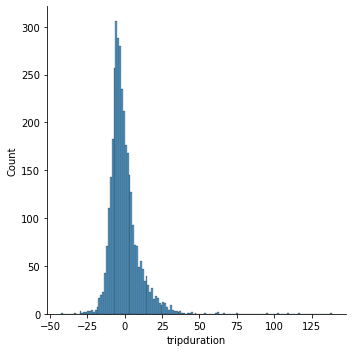

In [30]:
# Histogram of Forest errors
forest_predictions = forest.predict(X_test)
forest_error = y_test - forest_predictions
sns.displot(forest_error)

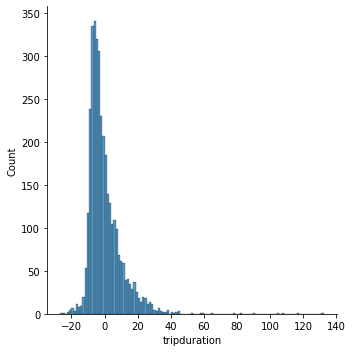

In [31]:
# Histogram of Gradient errors
gb_predictions = GBr.predict(X_test)
gb_error = y_test - gb_predictions
sns.displot(gb_error)

In [32]:
print('Forest MSE:', mean_squared_error(y_test, forest_predictions))
print('Forest RMSE:', np.sqrt(mean_squared_error(y_test, forest_predictions)))

Forest MSE: 107.15811653851368
Forest RMSE: 10.351720462730515


In [33]:
print('Gradient MSE:', mean_squared_error(y_test, gb_predictions))
print('Gradient RMSE:', np.sqrt(mean_squared_error(y_test, gb_predictions)))

Gradient MSE: 106.7681976454155
Gradient RMSE: 10.332869768143578


In [34]:
print('Forest MAE:', mean_absolute_error(y_test, forest_predictions))

Forest MAE: 7.063775349981083


In [35]:
print('Gradient MAE:',mean_absolute_error(y_test, gb_predictions))

Gradient MAE: 7.08351518218002


## Save the Model

In [36]:
from google.colab import drive
 
drive.mount('drive')

Mounted at drive


In [37]:
import joblib

In [38]:
# Save the models to Drive
 
joblib.dump(forest,'/content/drive/MyDrive/Projects/BigQuery/forest.joblib')
joblib.dump(GBr,'/content/drive/MyDrive/Projects/BigQuery/GBr.joblib')

['/content/drive/MyDrive/Projects/BigQuery/GBr.joblib']

# Predicting on brand new data

In [39]:
from google.colab import drive
 
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [40]:
import joblib
import pandas as pd
import numpy as np

In [41]:
# Load the models
loaded_rf = joblib.load('/content/drive/MyDrive/Projects/BigQuery/forest.joblib')
 
# Load the model
loaded_GBr = joblib.load('/content/drive/MyDrive/Projects/BigQuery/GBr.joblib')

In [42]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [43]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [44]:
project_id = 'sixth-flag-316719'

In [45]:
# Create a sampled DataFrame for predictions on Apr-May 2018
 
from google.cloud import bigquery
 
client = bigquery.Client(project=project_id)
 
sample_count = 40000
row_count = client.query('''
  SELECT 
    COUNT(*) as total
  FROM `bigquery-public-data.new_york_citibike.citibike_trips`''').to_dataframe().total[0]
 
evaluation_table = client.query('''
  SELECT
    tripduration/60 tripduration, 
                        starttime,
                        stoptime,
                        start_station_id,
                        start_station_name, 
                        end_station_id,
                        end_station_name,
                        usertype,
                        birth_year, 
                        gender
  FROM
    `bigquery-public-data.new_york_citibike.citibike_trips`
  WHERE 
    (EXTRACT (YEAR FROM starttime)=2018 AND 
      (EXTRACT (MONTH FROM starttime)=04 OR 
        EXTRACT (MONTH FROM starttime)=05))
    AND (tripduration>=3*60 AND tripduration<=3*60*60) # Trip duration between 3 minutes and 3 hours
    AND  birth_year is not NULL
    AND birth_year < 2007
    AND RAND() < %d/%d
''' % (sample_count, row_count)).to_dataframe()
 
# Pre-process dates and time
 
evaluation_table['Hour'] = evaluation_table['starttime'].apply(lambda time: time.hour)
evaluation_table['Month'] = evaluation_table['starttime'].apply(lambda time: time.month)
evaluation_table['Day of Week'] = evaluation_table['starttime'].apply( lambda time: time.dayofweek)
 
# Since the data consists of start time and duration, start and end time stamps can be dropped
 
evaluation_table = evaluation_table.drop(['starttime', 'stoptime'], axis=1)
 
# Map user type to 0 for customer or 1 for subscriber
 
evaluation_table['usertype'] = evaluation_table['usertype'].map({'Customer':0, 'Subscriber':1})
 
# Map gender to numeric variables
 
evaluation_table['gender'] = evaluation_table['gender'].map({'male':0, 'female':1, 'unknown':2})
 
# drop additional unnecessary variables
 
evaluation_table = evaluation_table.drop(['start_station_name', 'end_station_name', 'tripduration'], axis=1) # Trip duration is the y-variable
 
evaluation_table.dropna(inplace=True)

In [46]:
evaluation_table.head(3)

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
0,3360,3301,1,1996,0,16,5,6
1,3244,3474,1,1998,0,18,4,3
2,3145,492,1,1998,0,15,5,0


In [47]:
evaluation_table.describe()

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week
count,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000,1879.000000
mean,1550.043640,1539.771155,0.879723,1978.185205,0.435870,14.013305,4.588079,2.815859
std,1426.424266,1430.025313,0.325371,11.953485,0.663205,4.732159,0.492312,1.947704
min,72.000000,72.000000,0.000000,1900.000000,0.000000,0.000000,4.000000,0.000000
25%,383.000000,368.000000,1.000000,1969.000000,0.000000,10.000000,4.000000,1.000000
50%,503.000000,500.000000,1.000000,1980.000000,0.000000,15.000000,5.000000,3.000000
75%,3223.000000,3233.000000,1.000000,1988.000000,1.000000,18.000000,5.000000,4.000000
max,3684.000000,3686.000000,1.000000,2002.000000,2.000000,23.000000,5.000000,6.000000


In [48]:
RFpredictions = loaded_rf.predict(evaluation_table)
RFpredictions = pd.DataFrame(RFpredictions)

In [49]:
GBpredictions = loaded_GBr.predict(evaluation_table)
GBpredictions = pd.DataFrame(GBpredictions)

In [50]:
evaluation_table['RF_predicted duration'] = RFpredictions

In [51]:
evaluation_table['GB_predicted duration'] = GBpredictions

In [52]:
evaluation_table.head(15)

,start_station_id,end_station_id,usertype,birth_year,gender,Hour,Month,Day of Week,RF_predicted duration,GB_predicted duration
0,3360,3301,1,1996,0,16,5,6,9.515333,12.243598
1,3244,3474,1,1998,0,18,4,3,18.030667,13.645170
2,3145,492,1,1998,0,15,5,0,16.402167,13.394544
3,305,3169,1,1952,1,14,4,1,18.210333,15.293883
4,520,484,1,1946,0,10,5,3,14.156167,13.180863
5,500,509,1,1959,0,18,4,3,10.246833,11.143981
6,3002,328,1,1959,1,14,5,1,17.360333,16.409792
7,2010,320,0,1960,1,17,5,2,32.367500,32.527368
8,3423,3418,0,1961,1,11,5,4,39.557167,38.888094
9,3164,3173,1,1964,1,17,5,6,12.194667,14.495949


# EDA Dashboard with Dash

In [ ]:
!pip install jupyter-dash
!pip install pyngrok

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
 
dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
mmap = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'July', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
gmap = {0:'Male', 1:'Female', 2:'Unknown'}
evaluation_table.sort_values('Day of Week', inplace=True)
evaluation_table['Day of Week'] = evaluation_table['Day of Week'].map(dmap)
evaluation_table['Month'] = evaluation_table['Month'].map(mmap)
evaluation_table['gender'] = evaluation_table['gender'].map(gmap)

In [ ]:
# Stacked histogram showing Gradient predicted duration based on the gender column
fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']==0]['GB_predicted duration'], name="male trip duration"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']==1]['GB_predicted duration'], name="female trip duration"))
fig1.add_trace(go.Histogram(x=evaluation_table[evaluation_table['gender']==2]['GB_predicted duration'], name="unkown trip duration"))
fig1.update_layout(barmode='overlay', title='Stacked histogram showing predicted duration based on the gender column', xaxis_title='Predicted trip duration') # Overlay histograms
fig1.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Stacked histogram showing Gradient predicted durations based on the usertype column
fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=evaluation_table[evaluation_table['usertype']==0]['GB_predicted duration'], name="Customer"))
fig2.add_trace(go.Histogram(x=evaluation_table[evaluation_table['usertype']==1]['GB_predicted duration'], name="Subscriber"))
fig2.update_layout(barmode='overlay', title='Stacked histogram showing predicted durations based on the usertype column', xaxis_title='Predicted trip duration') # Overlay histograms
fig2.update_traces(opacity=0.65) # Reduce opacity to see all histograms
 
# Bar graph of trip counts by week day
fig3 = go.Figure()
fig3.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['GB_predicted duration'].count(), name="Trip counts by week day"))
fig3.update_layout(title='Trip counts by week day', xaxis_title='Day of Week')
 
# Bar graph of average predicted trip length by week day
fig4 = go.Figure()
fig4.add_trace(go.Bar(x=evaluation_table['Day of Week'].unique(), y=evaluation_table.groupby('Day of Week')['GB_predicted duration'].mean(), name="Average predicted trip duration by week day"))
fig4.update_layout(title='Mean predicted trip length by week day', xaxis_title='Day of Week')
 
# Bar graph of average predicted trip length by gender
fig5 = go.Figure()
fig5.add_trace(go.Bar(x=evaluation_table['gender'].unique(), y=evaluation_table.groupby('gender')['GB_predicted duration'].mean(), name="Average predicted trip duration by gender"))
fig5.update_layout(title='Mean trip length by gender', xaxis_title='Gender')

In [ ]:
# Dashboard with Dash
 
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output
from pyngrok import ngrok
 
app = JupyterDash(__name__)
 
app.layout = html.Div([
    dcc.Graph(figure=fig1),
    dcc.Graph(figure=fig2),
    dcc.Graph(figure=fig3),
    dcc.Graph(figure=fig4),
    dcc.Graph(figure=fig5),
    dash_table.DataTable(
        id='table',
        columns=[{"name": i, "id": i} 
                 for i in evaluation_table.columns],
        data=evaluation_table.to_dict('records'),
        style_cell=dict(textAlign='left'),
        style_header=dict(backgroundColor="paleturquoise"),
        style_data=dict(backgroundColor="lavender")
    )
])
 
app.run_server(mode='external')

Dash app running on:


<IPython.core.display.Javascript object>

In [ ]:
! ngrok authtoken 1vXlcIP1hk2NmY9UBuuSHU5gLHX_72emhyJmaGcTmoF6TQfKk

In [ ]:
public_url = ngrok.connect(addr = '8050')

In [ ]:
#ngrok url link
 
public_url

In [ ]:
ngrok.kill()